# INFORMAÇÕES IMPORTANTES:

## Dependências

## Especificações da Pesquisa

- Horizonte de previsão: 30 min, 1 hora, 3 horas


# Utilização de rede neural recorrente LSTM para previsões intradiárias do mercado de ações. 

## SEI LA SABE

In [15]:
import pandas as pd
import tensorflow as tf
import numpy as np


#-----------------------------------------------------------
#Lê os dados do arquivo CSV.
#-----------------------------------------------------------
data = pd.read_csv('/home/bene/MachineLearning/TCC/Base de Dados/BPAC_30m_2019.csv') 
data.head()
#print(df)
#df.info()

,time,open,high,low,close,Volume
0,2019-01-02T10:00:00-02:00,5.9125,5.9375,5.9125,5.9300,7600
1,2019-01-02T10:30:00-02:00,5.9300,5.9700,5.9200,5.9525,46800
2,2019-01-02T11:00:00-02:00,5.9575,5.9925,5.9400,5.9800,52800
3,2019-01-02T11:30:00-02:00,5.9875,6.0050,5.9825,5.9900,57200
4,2019-01-02T12:00:00-02:00,5.9950,6.0350,5.9900,6.0175,60400


In [16]:
#-----------------------------------------------------------
#Escolhe a coluna de série temporal única de interesse.
#-----------------------------------------------------------
symbol = "close"

data = pd.DataFrame(data[symbol])
data.head()


,close
0,5.9300
1,5.9525
2,5.9800
3,5.9900
4,6.0175


In [17]:
#-----------------------------------------------------------
#Renomeia a única coluna para price
#-----------------------------------------------------------

data.rename(columns={symbol: 'price'}, inplace=True)

data.head()

,price
0,5.9300
1,5.9525
2,5.9800
3,5.9900
4,6.0175


In [18]:
#-----------------------------------------------------------
# Calcula o log de retorno e define a direção como uma coluna binária.
#-----------------------------------------------------------

#Log Retorno
data['return'] = np.log(data['price']/data['price'].shift(1))

#Coluna binária
data['direction'] = np.where(data['return'] > 0, 1, 0)
#data.head()

display(data)

,price,return,direction
0,5.9300,NaN,0
1,5.9525,0.003787,1
2,5.9800,0.004609,1
3,5.9900,0.001671,1
4,6.0175,0.004580,1
...,...,...,...
3912,18.8975,0.002649,1
3913,18.9000,0.000132,1
3914,18.9350,0.001850,1
3915,18.9175,-0.000925,0


In [19]:
#Para a previsão do mercado de ações, é crucial encontrar dependências de tempo bem definidas
lags = 4

cols = []
#-----------------------------------------------------------
# Cria os Lagged Data
#-----------------------------------------------------------
for lag in range(1, lags + 1):
     col = f'lag_{lag}'
#-----------------------------------------------------------
# Cria novas colunas DataFrame com os retornos de log deslocados pelo respectivo número de atrasos
#-----------------------------------------------------------
     data[col] = data['return'].shift(lag)
     cols.append(col)
#-----------------------------------------------------------
# Exclui as linhas que contêm valores NaN.
#-----------------------------------------------------------
data.dropna(inplace=True)

In [20]:
#-----------------------------------------------------------
# Imprime as cinco linhas finais indicando os “padrões” emergentes nas quatro colunas de recursos
#-----------------------------------------------------------

#data.round(4).tail() 
display(data)

,price,return,direction,lag_1,lag_2,lag_3,lag_4
5,6.0850,0.011155,1,0.004580,0.001671,0.004609,0.003787
6,6.1425,0.009405,1,0.011155,0.004580,0.001671,0.004609
7,6.1350,-0.001222,0,0.009405,0.011155,0.004580,0.001671
8,6.1625,0.004472,1,-0.001222,0.009405,0.011155,0.004580
9,6.1700,0.001216,1,0.004472,-0.001222,0.009405,0.011155
...,...,...,...,...,...,...,...
3912,18.8975,0.002649,1,-0.001326,-0.001324,-0.001718,-0.003428
3913,18.9000,0.000132,1,0.002649,-0.001326,-0.001324,-0.001718
3914,18.9350,0.001850,1,0.000132,0.002649,-0.001326,-0.001324
3915,18.9175,-0.000925,0,0.001850,0.000132,0.002649,-0.001326


In [21]:
#-----------------------------------------------------------
# Importa o pacote TensorFlow.
#-----------------------------------------------------------
import tensorflow as tf
#-----------------------------------------------------------
# Importa o objeto de modelo necessário do Keras
#-----------------------------------------------------------
from keras.models import Sequential
#-----------------------------------------------------------
# Importa o objeto de camada relevante do Keras
#-----------------------------------------------------------
from keras.layers import Dense
#-----------------------------------------------------------
# Importa a LSTM
#-----------------------------------------------------------
from tensorflow.keras.layers import LSTM
#-----------------------------------------------------------
# Importa Layer weight regularizers
# https://keras.io/api/layers/regularizers/
#-----------------------------------------------------------
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import Adam, RMSprop, Adamax

#optimizer = Adam(learning_rate=0.0001)

# https://keras.io/api/optimizers/adamax/
optimizer = Adamax(learning_rate=0.001)

In [22]:
#-----------------------------------------------------------
# Um modelo Sequencial é instanciado.
#PORQU
#-----------------------------------------------------------
model=Sequential()

#-----------------------------------------------------------
# As camadas ocultas e a camada de saída são definidas.
#-----------------------------------------------------------
# Se cada amostra de entrada tiver 4 passos de tempo, onde cada passo de tempo 
# consiste em 1 valor de recurso, então a forma de entrada seria (4, 1).
# https://stackoverflow.com/questions/61153831/how-to-properly-set-the-input-shape-of-lstm-layers
# input_shape = Deve ser 3 dimensôes, batch_size, timestep, the number of units in one input sequence
model.add(LSTM(100,activation='relu', input_shape=(lags,1),return_sequences=True))
model.add(LSTM(50,activation='relu',return_sequences=True))
model.add(LSTM(10,activation='relu',return_sequences=True))
model.add(Dense(1, activation='sigmoid'))

# model.add(LSTM(8, input_shape=(lags,1),return_sequences=True))
# model.add(LSTM(4,kernel_regularizer=regularizers.L1(0.02),return_sequences=True))
# model.add(LSTM(2,kernel_regularizer=regularizers.L1(0.02),return_sequences=True))
# model.add(Dense(1, activation='sigmoid'))

#-----------------------------------------------------------
# Compila o objeto de modelo Sequencial para classificação.
#-----------------------------------------------------------
# https://keras.io/api/losses/probabilistic_losses/#binary_crossentropy-function
# https://keras.io/api/losses/
model.compile(optimizer=optimizer,
 loss='binary_crossentropy',
metrics=['accuracy'])
# https://keras.io/api/metrics/
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4, 100)            40800     
_________________________________________________________________
lstm_4 (LSTM)                (None, 4, 50)             30200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 4, 10)             2440      
_________________________________________________________________
dense_1 (Dense)              (None, 4, 1)              11        
Total params: 73,451
Trainable params: 73,451
Non-trainable params: 0
_________________________________________________________________


In [23]:
#-----------------------------------------------------------
# Define a data limite entre os dados de treinamento e teste.
#-----------------------------------------------------------
cutoff = 2740

#-----------------------------------------------------------
# Define os conjuntos de dados de treinamento e teste.
#-----------------------------------------------------------
training_data = data[data.index < cutoff].copy()
test_data = data[data.index >= cutoff].copy()

display(training_data)
display(test_data)

,price,return,direction,lag_1,lag_2,lag_3,lag_4
5,6.0850,0.011155,1,0.004580,0.001671,0.004609,0.003787
6,6.1425,0.009405,1,0.011155,0.004580,0.001671,0.004609
7,6.1350,-0.001222,0,0.009405,0.011155,0.004580,0.001671
8,6.1625,0.004472,1,-0.001222,0.009405,0.011155,0.004580
9,6.1700,0.001216,1,0.004472,-0.001222,0.009405,0.011155
...,...,...,...,...,...,...,...
2735,13.4300,-0.003902,0,0.007071,-0.000187,0.000373,-0.001120
2736,13.7450,0.023184,1,-0.003902,0.007071,-0.000187,0.000373
2737,13.7750,0.002180,1,0.023184,-0.003902,0.007071,-0.000187
2738,13.8250,0.003623,1,0.002180,0.023184,-0.003902,0.007071


,price,return,direction,lag_1,lag_2,lag_3,lag_4
2740,13.8300,-0.002167,0,0.002528,0.003623,0.002180,0.023184
2741,13.8050,-0.001809,0,-0.002167,0.002528,0.003623,0.002180
2742,13.8350,0.002171,1,-0.001809,-0.002167,0.002528,0.003623
2743,13.7025,-0.009623,0,0.002171,-0.001809,-0.002167,0.002528
2744,13.7500,0.003461,1,-0.009623,0.002171,-0.001809,-0.002167
...,...,...,...,...,...,...,...
3912,18.8975,0.002649,1,-0.001326,-0.001324,-0.001718,-0.003428
3913,18.9000,0.000132,1,0.002649,-0.001326,-0.001324,-0.001718
3914,18.9350,0.001850,1,0.000132,0.002649,-0.001326,-0.001324
3915,18.9175,-0.000925,0,0.001850,0.000132,0.002649,-0.001326


In [24]:
#-----------------------------------------------------------
# Normaliza os dados de recursos por normalização gaussiana.
#-----------------------------------------------------------
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std
test_data_ = (test_data - mu) / std 

In [25]:
training_data[cols]

,lag_1,lag_2,lag_3,lag_4
5,0.004580,0.001671,0.004609,0.003787
6,0.011155,0.004580,0.001671,0.004609
7,0.009405,0.011155,0.004580,0.001671
8,-0.001222,0.009405,0.011155,0.004580
9,0.004472,-0.001222,0.009405,0.011155
...,...,...,...,...
2735,0.007071,-0.000187,0.000373,-0.001120
2736,-0.003902,0.007071,-0.000187,0.000373
2737,0.023184,-0.003902,0.007071,-0.000187
2738,0.002180,0.023184,-0.003902,0.007071


In [26]:
%%time
#-----------------------------------------------------------
# Ajusta o modelo ao conjunto de dados de treinamento.
#-----------------------------------------------------------
# model.fit(training_data[cols], # Lags
#    training_data['direction'], # 0 e 1
#    epochs=250, verbose=False, batch_size=100,
#    validation_split=0.5, shuffle=False)

model.fit(training_data[cols], # Lags
    training_data['direction'], # 0 e 1
    epochs=100, verbose=False, batch_size=32,
    validation_split=0.2, shuffle=False)

CPU times: user 1min 50s, sys: 8.54 s, total: 1min 58s
Wall time: 55 s


In [27]:
res = pd.DataFrame(model.history.history)
res.head()

,loss,accuracy,val_loss,val_accuracy
0,0.693141,0.509712,0.693072,0.521024
1,0.693053,0.516453,0.692985,0.521024
2,0.692992,0.516453,0.692908,0.521024
3,0.692938,0.516453,0.692841,0.521024
4,0.692892,0.516453,0.692781,0.521024


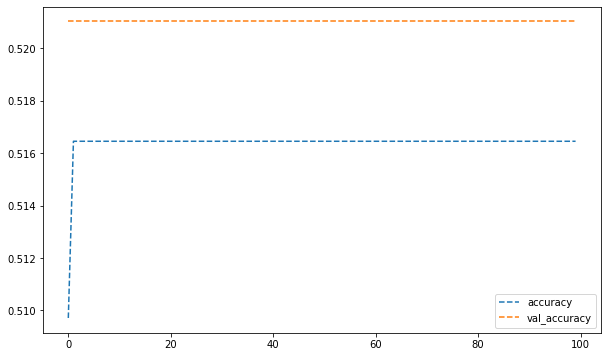

In [28]:
#-----------------------------------------------------------
# Precisão do classificador LSTM nos dados de treinamento e validação por etapa de treinamento
#-----------------------------------------------------------

# Segundo esse link, o melhor é ajustar os valores de accuracy, val_accuracy 
# para que os valores estejam o mais próximos possiveis.
# https://stackoverflow.com/questions/51335133/keras-how-come-accuracy-is-higher-than-val-acc

res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [29]:
model.evaluate(training_data[cols], training_data['direction'])

86/86 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5174


[0.6925443410873413, 0.5173674821853638]

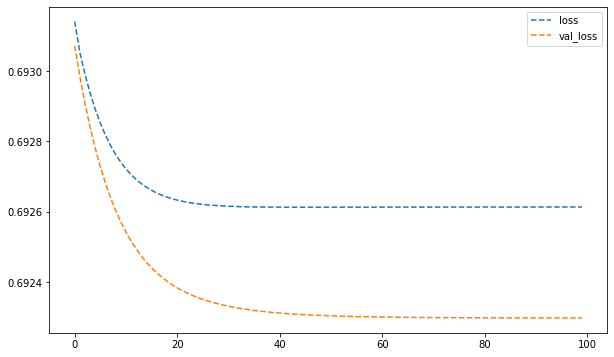

In [30]:
res[['loss', 'val_loss']].plot(figsize=(10, 6), style='--');

Proximos passos:

- Mandar dúvidas para o Arthur
- Entender alguns parametros da LSTM:
      - activation
      - input_shape
- Valores de perda (como diminui-los)
- Como aumentar a acurácia
- Como os dados de testes entrariam?? (Nesse exemplo, o dado de teste entra como dados de validação: https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)
- # PORQUE SEQUENCIAL?? 
# VER ARTIGO DO ARTHUR DO PORQUE USAR RELU
# Porque é DENSA e não do tipo LSTM

# Olhar quanto 0 e quantos 1
extrair matriz de confusão 
se acuracia deu muito alta, ve se tem mais 1 ou mais 0

# Reforçar Epócas

# batch_size no model.fit


https://www.baeldung.com/wp-content/uploads/sites/4/2020/12/epoch-training-curve.png

# Acuracia super ajustada